In [1]:
using LinearAlgebra, Plots;
function plus(x)
    return max(x, 0)
end

function minus(x)
    return max(-x, 0)
end

function create_D_vecs(u_vec, t_n, h, C_H) # returns Dplusminus and Dminusplus vectors
    Dplus = [diff(u_vec); 0] ./ h
    Dminus = [0; diff(u_vec)] ./ h
    Dplus[end] = (u_vec[1] - u_vec[end]) / h
    Dminus[1]= (u_vec[1] - u_vec[end]) / h 
    Dplusminus = minus.(Dplus)
    Dminusplus = plus.(Dminus)
    Dplusplus = plus.(Dplus)
    Dminusminus = minus.(Dminus)
    return C_H .* (Dplusminus, Dminusplus, Dplusplus, Dminusminus)
end

function g_func(u_vec, t_n, h, C_H)
    (Dplusminus, Dminusplus, temp, temp) = create_D_vecs(u_vec, t_n, h, C_H)
    return C_H .* (Dplusminus .^2 + Dminusplus .^2)
end

function create_Dg_mat(v, t_n, N_h, h, C_H) # verified is correct
    (Dplusminus, Dminusplus, temp, temp) = create_D_vecs(v, t_n, h, C_H);
    Dg_mat = zeros(N_h, N_h)
    tridiag = Tridiagonal(-Dminusplus[2:end], Dplusminus + Dminusplus, -Dplusminus[1:end-1])
    Dg_mat[1, N_h] = -Dminusplus[1]
    Dg_mat[N_h, 1] = -Dplusminus[end]
    Dg_mat += tridiag
    Dg_mat *= 2/h
    return Dg_mat
end
using SpecialFunctions: gamma, loggamma, zeta
function TS(m, α, N_h, R)
    if m==0
        return 0
    end
    K_α = 0.0
    for ν in -R:1:R
        K_α += exp( loggamma( abs(m - N_h*ν) - α/2 )  - loggamma( ( abs(m - N_h*ν) + 1 + α/2) )  )
    end
    return K_α
end
    

function create_DPL_matrix(N_h, α, h, R)
    DPL_mat = Matrix{Float64}(undef, N_h, N_h)
    zeta_term= zeta(1+α)
    for i in 1:N_h
        for j in 1:N_h
            DPL_mat[i,j] = TS(abs(i-j), α, N_h, R)
        end
    end
    for γ in 1:N_h
        DPL_mat[γ, γ] = -(sum([TS(β-γ, α, N_h, R) for β in 1:N_h]) + 2*zeta_term - 
        sum([1/k^(1+α) for k in 1:((R+1)*N_h - γ) ]) - sum([1/k^(1+α) for k in 1:(R*N_h + γ - 1) ]))
    end
    c_α = 2^α * gamma((1+α)/2) / (√π * abs(gamma(-α/2)) )
    return -c_α / (h^α) * DPL_mat
end

function tranport_matrix(U, t_n, N_h, h, C_H) # verified!
    (DPM, DMP, DPP, DMM) = create_D_vecs(U, t_n, h, C_H);
    TU_mat = zeros(N_h, N_h)
    tridiag = Tridiagonal(DMM[2:end], -DPM - DMP, DPP[1:end-1])
    TU_mat[1, N_h] = DMM[1]
    TU_mat[N_h, 1] = DPP[end]
    # tridiag = Tridiagonal(DMM[1:end-1], -(DMP + DPM), DPP[2:end])
    # TU_mat[1, N_h] = DMM[end]
    # TU_mat[N_h, 1] = DPP[1]
    TU_mat += tridiag
    TU_mat *= 2/h # not by h
    return TU_mat
end


function mathcalF(U_np1, U_n, M_n, DPL_matrix, x_vec, n, N_h, Δt, h, ν, α, R,δ, C_H)
    return U_np1 - U_n + Δt*( ν*DPL_matrix*U_np1 + g_func(U_np1, n*Δt, h, C_H) - F_h(M_n, x_vec, 2-n*Δt,δ))
end

function J_F(x, DPL_matrix, t_n, N_h, Δt, h, ν, α, R, C_H) # verified is correct
    Dg_mat = create_Dg_mat(x, t_n, N_h, h, C_H)
    return 1.0I(N_h) + Δt*(ν*DPL_matrix + Dg_mat)
end

function HJB_step(U_n, M_n, DPL_matrix, num_it_HJB, x_vec, n, N_h, Δt, h, ν, α, R,δ,C_H)
    U_np1 = U_n 
    for _ in num_it_HJB
        jacobi = J_F(U_np1, DPL_matrix, n*Δt, N_h, Δt, h, ν, α, R, C_H)
        F_vec = mathcalF(U_np1, U_n, M_n, DPL_matrix, x_vec, n, N_h, Δt, h, ν, α, R,δ,C_H)
        δ = jacobi \ F_vec
        U_np1 = U_np1 - δ
    end
    return U_np1
end

function HJB_solve(M_mat, num_it_HJB, x_vec, N_h, Δt, N_T, h, ν, α, R, δ, C_H)
    U_mat = Array{Float64}(undef, N_h, N_T)
    U_mat[:,1] = G_h(M_mat[:,1])
    DPL_matrix = create_DPL_matrix(N_h, α, h, R)
    for n in 1:(N_T-1)
        U_mat[:, n+1]= HJB_step(U_mat[:, n], M_mat[:, n], DPL_matrix, num_it_HJB, x_vec, n, N_h, Δt, h, ν, α, R,δ,C_H)
    end
    return U_mat
end

function FPK_step(U_np1, M_np1, n, DPL_mat, N_h, Δt, h, ν, α, R, C_H) # not exactly verified, but DPL and TU is verified.
    TU = tranport_matrix(U_np1, n*Δt, N_h, h, C_H)
    total_mat = 1.0I(N_h) + Δt *(ν*DPL_mat - TU)
    M_n = total_mat \ M_np1
    return M_n
end
function FPK_solve(U_mat, M_T, N_h, Δt, N_T, h, ν, α, R, C_H)
    M_mat = Array{Float64}(undef, N_h, N_T)
    M_mat[:,end] = M_T
    DPL_mat = create_DPL_matrix(N_h, α, h, R)
    for j in 1:(N_T-1)
        M_mat[:, N_T-j]= FPK_step(U_mat[:, N_T-j+1], M_mat[:, N_T-j+1], N_T-j+1, DPL_mat, N_h, Δt, h, ν, α, R, C_H)
    end
    return M_mat
end

function MFG_solve(M_T, cv)
    (α, h, N_h, Δt, N_T, ν, num_it_MFG, num_it_HJB, x_vec, R, δ, C_H) = cv;
    M_mat = Array{Float64}(undef, N_h, N_T); M_mat .= M_T;
    U_mat = Array{Float64}(undef, N_h, N_T);
    for _ in 1:num_it_MFG
        U_mat = HJB_solve(M_mat, num_it_HJB, x_vec, N_h, Δt, N_T, h, ν, α, R, δ, C_H)
        M_mat = FPK_solve(U_mat, M_T, N_h, Δt, N_T, h, ν, α, R, C_H)
    end
    return (U_mat, M_mat)
end

using QuadGK;

function ϕ_δ(x, δ)
    1/(δ* sqrt(2*π)) * exp(-x^2 / (2*δ^2))
end

function conv_term(m_vec, x_vec, δ)
    h = x_vec[2] - x_vec[1]
    N_h = length(m_vec)
    conv_vec = Vector{Float64}(undef, N_h)
    for j in 1:N_h
        conv_vec[j] = h*sum( [ m_vec[i] * ϕ_δ(x_vec[j] - x_vec[i],δ) for i in 1:N_h]) # * h
    end
    return conv_vec
end

# f_func = (x, t) -> cos(2*pi*(x-t^2))^2
f_func = (x, t) -> 5*(x − 0.5(1 − sin(2*π*t)))^2

function F_h(M, x_vec, t_n,δ)
    ϕm = conv_term(M, x_vec,δ)
    fⁿ = [f_func(x_i, t_n) for x_i in x_vec]
    return ϕm + fⁿ
end

### INITIAL AND TERMINAL CONDITIONS

function G_h(M)
    return zeros(length(M))
end

# m_T_func_unnorm = (x) -> exp(-50*(x-0.5)^2)
m_T_func_unnorm = (x) -> exp(-(x-0.5)^2/0.1^2)
oneOverC, error = quadgk(m_T_func_unnorm, 0, 1);

function m_T_func(x)
    return 1/oneOverC * m_T_func_unnorm(x) 
end

m_T_func (generic function with 1 method)

In [12]:
println("START")
### Solution for different h

h_reference = 1/2^8
h_list = [1/2, 1/2^2, 1/2^3, 1/2^4, 1/2^5, 1/2^6, h_reference]

M_list = Array{Float64}[]
U_list = Array{Float64}[]

println("hlist: ", h_list)
println("h_reference: ", h_reference)
println("M_list: ", M_list)
println("U_list", U_list)

for h in h_list
    println("")
    println("start for loop, h=", h)
    ####### NB Might take some time to run
    α = 1.0 #1.5
    x_vec = -1:h:(2-h);
    N_h =length(x_vec);
    Δt = 0.01
    t_vec = 0:Δt:(2-Δt)
    N_T =length(t_vec)
    ν=0.09^2
    num_it_MFG=50
    num_it_HJB=20
    δ = 0.4
    R=30
    C_H = 0.5
    cv = (α, h, N_h, Δt, N_T, ν, num_it_MFG, num_it_HJB, x_vec, R, δ, C_H); # create a constant-vector, to avoid clutter for all constants we need.
    println("C_H: ", C_H)
    #terminal condition
    M_T =  m_T_func.(x_vec);

    println("Running MFG_solve with h=", h)
    (U_mat, M_mat) = MFG_solve(M_T, cv);
    M_mat = reverse(M_mat, dims=2);
    U_mat = reverse(U_mat, dims=2);
    ############

    println("Done running MFG_sovle with h=", h)
    #println("M_mat: ")
    #println(M_mat)
    
    println("size(M_mat): ", size(M_mat))
    println("size(U_mat): ", size(U_mat))

    push!(M_list, M_mat)
    push!(U_list, U_mat)
    println("!!!!!!!!!!!!!!")
end

println("DONE")
println("size(M_list): ", size(M_list))
println("size(U_list): ", size(U_list))

START
hlist: [0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.00390625]
h_reference: 0.00390625
M_list: Array{Float64}[]
U_listArray{Float64}[]

start for loop, h=0.5
C_H: 0.5
Running MFG_solve with h=0.5
Done running MFG_sovle with h=0.5
size(M_mat): (6, 200)
size(U_mat): (6, 200)
!!!!!!!!!!!!!!

start for loop, h=0.25
C_H: 0.5
Running MFG_solve with h=0.25
Done running MFG_sovle with h=0.25
size(M_mat): (12, 200)
size(U_mat): (12, 200)
!!!!!!!!!!!!!!

start for loop, h=0.125
C_H: 0.5
Running MFG_solve with h=0.125
Done running MFG_sovle with h=0.125
size(M_mat): (24, 200)
size(U_mat): (24, 200)
!!!!!!!!!!!!!!

start for loop, h=0.0625
C_H: 0.5
Running MFG_solve with h=0.0625
Done running MFG_sovle with h=0.0625
size(M_mat): (48, 200)
size(U_mat): (48, 200)
!!!!!!!!!!!!!!

start for loop, h=0.03125
C_H: 0.5
Running MFG_solve with h=0.03125
Done running MFG_sovle with h=0.03125
size(M_mat): (96, 200)
size(U_mat): (96, 200)
!!!!!!!!!!!!!!

start for loop, h=0.015625
C_H: 0.5
Running MFG_

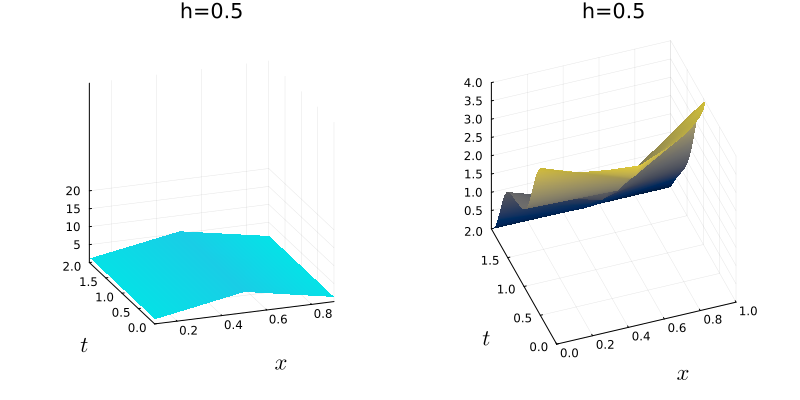

HI
[0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.00390625]
!!
size(U_list): (7,)
----
i: 1
Display:
!!!!!!!!!
----
i: 2
Display:
!!!!!!!!!
----
i: 3
Display:
!!!!!!!!!
----
i: 4
Display:
!!!!!!!!!
----
i: 5
Display:
!!!!!!!!!
----
i: 6
Display:
!!!!!!!!!
----
i: 7
Display:
!!!!!!!!!


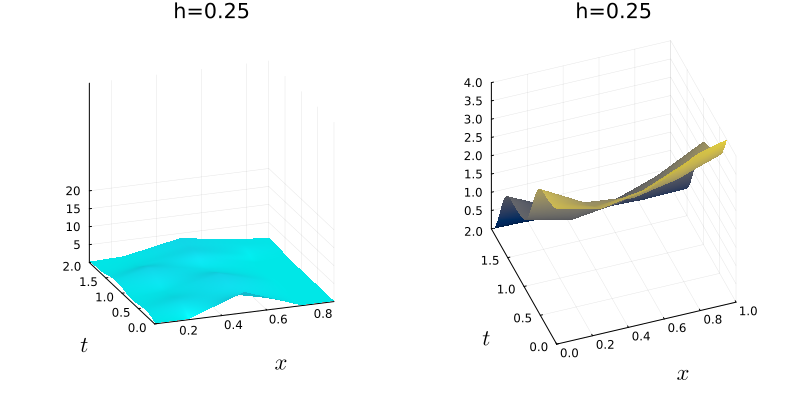

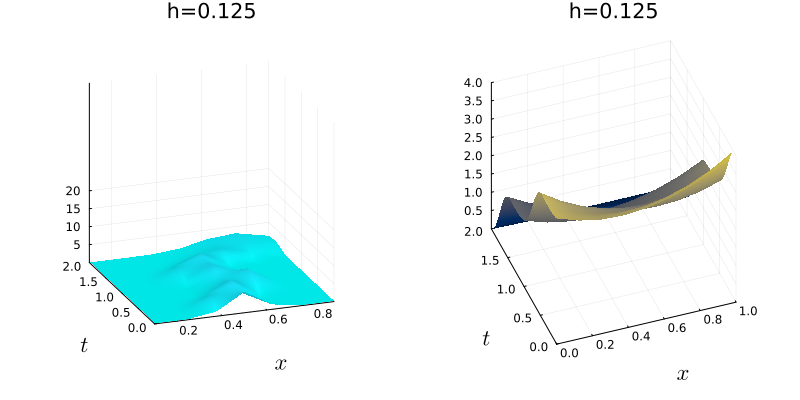

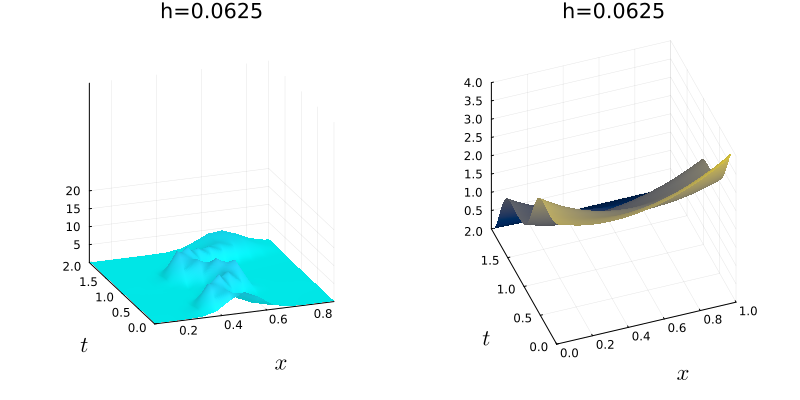

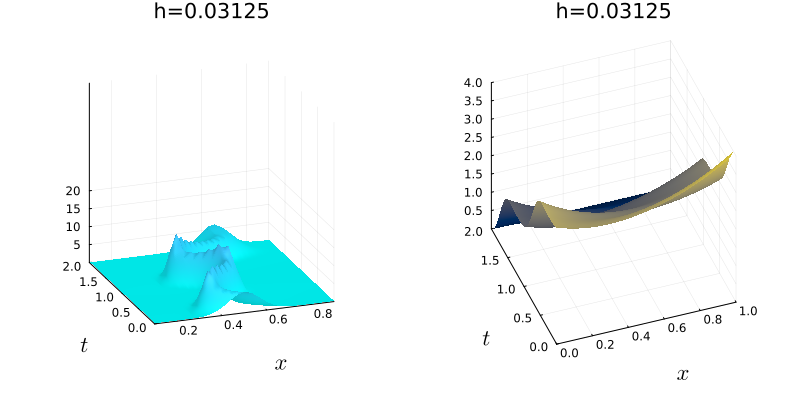

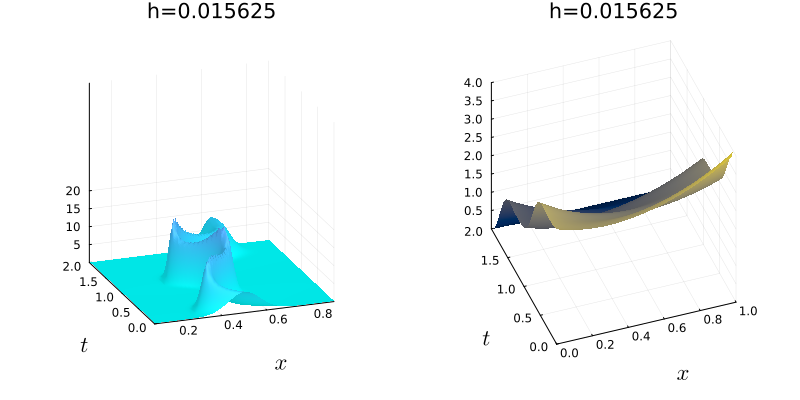

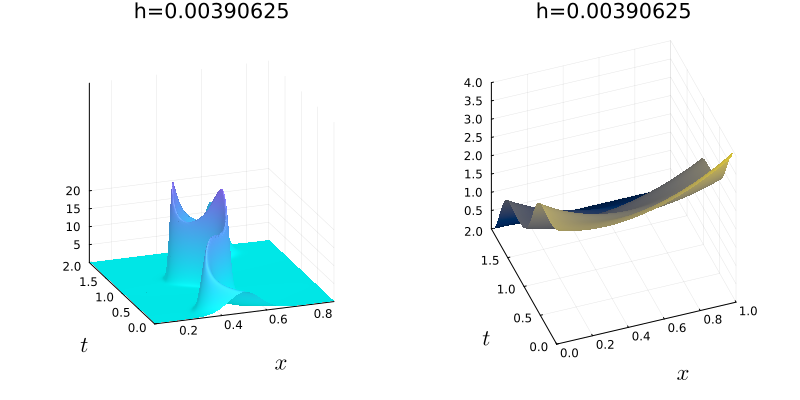

In [13]:
# plotusing Plots, LaTeXStrings;
using DelimitedFiles;
using Plots, LaTeXStrings;
println("HI")
println(h_list)
println("!!")
println("size(U_list): ", size(U_list))

for (i,h) in enumerate(h_list)
    println("----")
    println("i: ", i)
    x_vec = -1:h:(2-h);
    N_h =length(x_vec);
    
    α = 1.0 #1.5
    Δt = 0.01
    t_vec = 0:Δt:(2-Δt)
    N_T =length(t_vec)
    ν=0.09^2
    num_it_MFG=50
    num_it_HJB=20
    δ = 0.4
    R=30
    C_H = 0.5

    plot_U_mat = U_list[i];
    plot_M_mat = M_list[i];

    zticks1 = 5:5:20
    p1 = plot(t_vec, x_vec, plot_M_mat, ylabel=L"x", xlabel=L"t",  st=:surface, labelfontsize=15, zlim=(0,50),
    color=cgrad(:cool, rev=false), size=(500, 500), xlim=(0,2), ylim=(0.1,0.9), legend=false, camera=(90- 20, 20), xflip=true, zticks=zticks1, title=L"m(x,t)")
    zticks2 = 0.5:0.5:4
    p2 = plot(t_vec, x_vec, plot_U_mat, xlabel=L"t", ylabel=L"x",   st=:surface, labelfontsize=15,
    color=:cividis, size=(500, 500), ylim=(0, 1), xlim=(0,2), zlim=(0, 4), legend=false, camera=(90- 20, 40), xflip=true, zticks=zticks2, title=L"u(x,t)")

    p = plot(p1, p2, layout=2, size=(800, 400), title="h="*string(h))
    println("Display:")
    display(p)
    # println("i: ", i)
    # if i==1
    #     break
    # end
    println("!!!!!!!!!")
end

In [23]:
println(size(U_list[7]))
display(U_list[7])
typeof(U_list[7])
display(U_list[7][:,1])

768×200 Matrix{Float64}:
 8.11491  8.10149  8.0936   8.09141  …  0.322205  0.22217   0.117092  0.0
 8.07996  8.0662   8.05791  8.05527     0.339597  0.237534  0.116587  0.0
 8.04508  8.03094  8.02221  8.01907     0.361264  0.236483  0.116013  0.0
 8.01025  7.99569  7.98646  7.98273     0.359652  0.235329  0.115429  0.0
 7.97583  7.96093  7.9513   7.9471      0.357912  0.234157  0.114842  0.0
 7.94129  7.92595  7.91579  7.91097  …  0.356147  0.232979  0.114255  0.0
 7.9063   7.89033  7.8794   7.87362     0.354373  0.2318    0.113668  0.0
 7.87045  7.85354  7.84141  7.83416     0.352597  0.230621  0.113082  0.0
 7.83572  7.8181   7.80509  7.79672     0.350821  0.229444  0.112498  0.0
 7.80184  7.78371  7.77003  7.76083     0.349046  0.228269  0.111914  0.0
 ⋮                                   ⋱                                
 8.48961  8.49048  8.49672  8.50854     0.294874  0.201176  0.102919  0.0
 8.44539  8.44416  8.44818  8.45761  …  0.296502  0.202274  0.103474  0.0
 8.40344  8.4006

768-element Vector{Float64}:
 8.114910753878814
 8.079960150770225
 8.045082051957111
 8.010247496844903
 7.975828737295446
 7.941286700102829
 7.906299176335071
 7.870452235576601
 7.835717940041334
 7.801837374455943
 ⋮
 8.489613976611025
 8.445387782772926
 8.403437871209812
 8.36182752856058
 8.320383141130423
 8.279074679322425
 8.237880333186599
 8.196790794704658
 8.155802043778612

(768, 200)


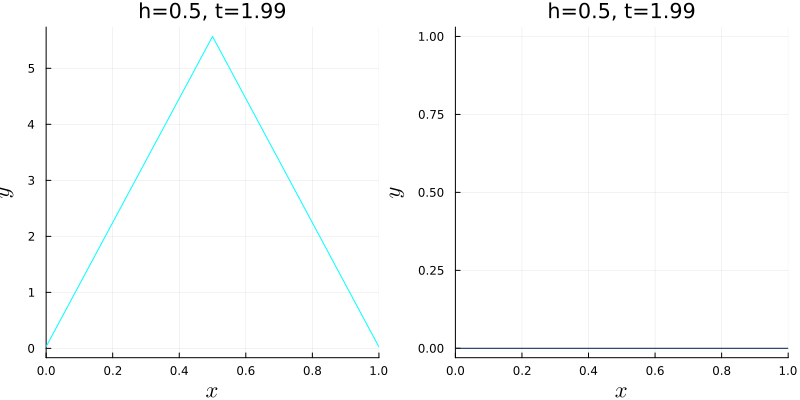

FINAL TIME PLOTS
----
i: 1
time_index: 200
Display:
!!!!!!!!!
----
i: 2
time_index: 200
Display:
!!!!!!!!!
----
i: 3
time_index: 200
Display:
!!!!!!!!!
----
i: 4
time_index: 200
Display:
!!!!!!!!!
----
i: 5
time_index: 200
Display:
!!!!!!!!!
----
i: 6
time_index: 200
Display:
!!!!!!!!!
----
i: 7
time_index: 200
Display:
!!!!!!!!!


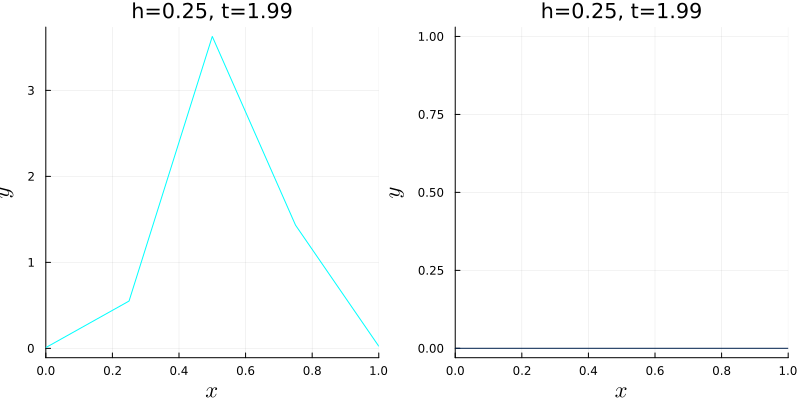

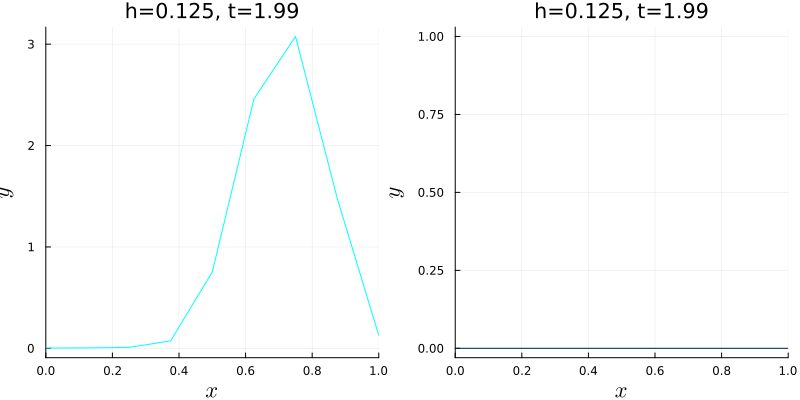

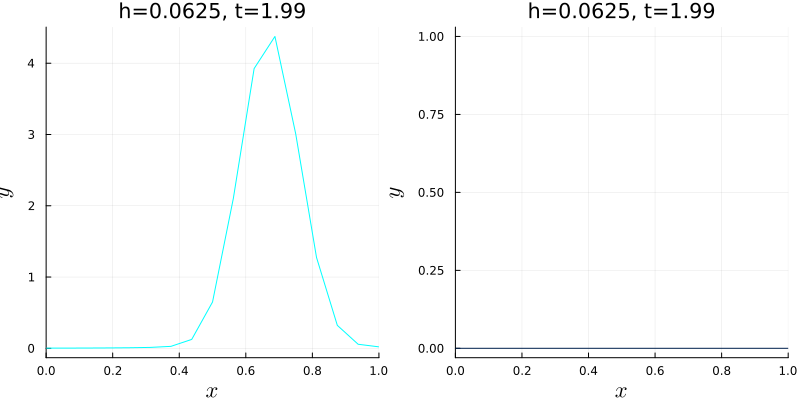

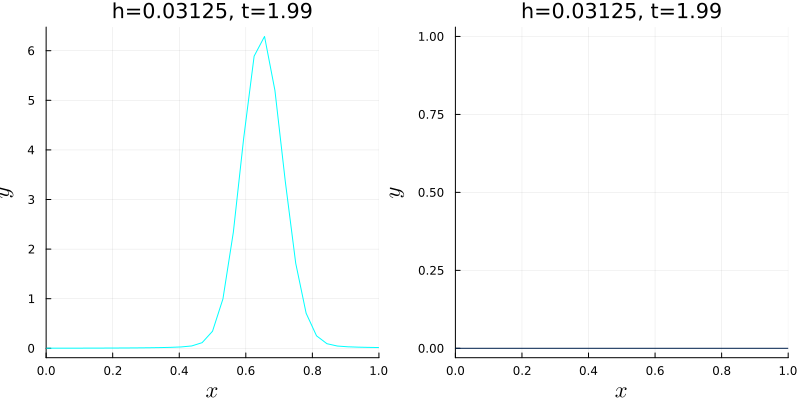

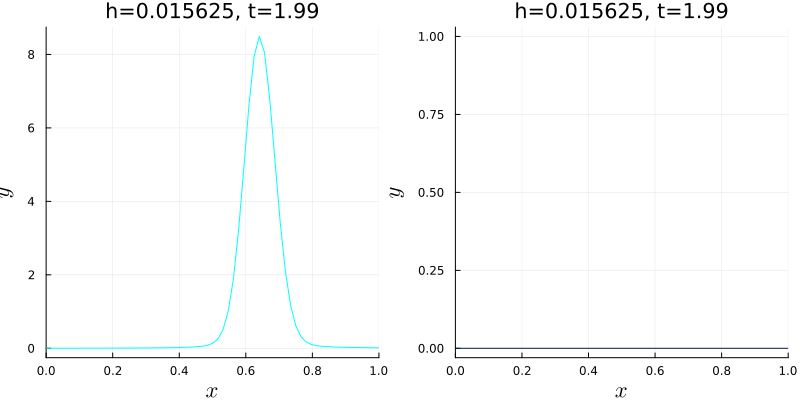

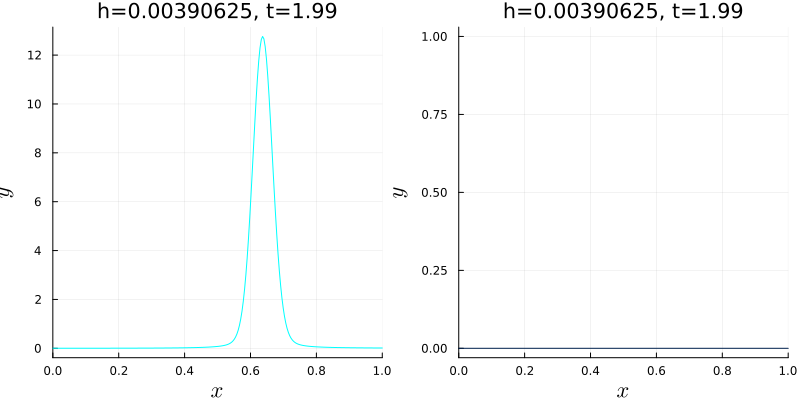

In [37]:
println("FINAL TIME PLOTS")

for (i,h) in enumerate(h_list)
    println("----")
    println("i: ", i)
    x_vec = -1:h:(2-h);
    N_h =length(x_vec);
    
    α = 1.0 #1.5
    Δt = 0.01
    t_vec = 0:Δt:(2-Δt)
    N_T =length(t_vec)
    ν=0.09^2
    num_it_MFG=50
    num_it_HJB=20
    δ = 0.4
    R=30
    C_H = 0.5

    time_index = div(length(t_vec),1)
    println("time_index: ", time_index)

    plot_U_mat_final = U_list[i][:,time_index];
    plot_M_mat_final = M_list[i][:,time_index];

    p1 = plot(x_vec, plot_M_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=15,
    color=cgrad(:cool, rev=false), size=(500, 500), xlim=(0,1), legend=false, title=L"m(x,200)")
    zticks2 = 0.5:0.5:4
    p2 = plot(x_vec, plot_U_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=15,
    color=:cividis, size=(500, 500), xlim=(0, 1), legend=false, title=L"u(x,200)")

    p = plot(p1, p2, layout=2, size=(800, 400), title="h="*string(h)*", t="*string(t_vec[time_index]))
    println("Display:")
    display(p)
    # println("i: ", i)
    # if i==1
    #     break
    # end
    println("!!!!!!!!!")
end

In [65]:
println(maximum(U_list[7][:,200]))
println(abs(-200))

println([1,2,3,4,5]-[1,1,1,1,1])
println("h_list: ", h_list)
println("mass: ")
println(h_list[4]*sum(M_list[4][:,200]))
println(h_list[5]*sum(M_list[5][:,200]))
println(h_list[6]*sum(M_list[6][:,200]))
println(h_list[7]*sum(M_list[7][:,200]))

0.0
200
[0, 1, 2, 3, 4]
h_list: [0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.00390625]
mass: 
0.9998878566974793
0.999887856716053
0.9998878567223962
0.9998878567229306


In [66]:
#assume vec, wrt_vec same sizes

function relative_max_error(vec, wrt_vec)
    max_difference = maximum(abs(vec-wrt_vec))
    max_rel_error = max_difference/maximum(abs(wrt_vec))
    return max_rel_error
end

function relative_l1_error(vec, wrt_vec,h)
    l1 = sum(abs(vec-wrt_vec)) #*h
    l1_rel_error = l1/sum(abs(wrt_vec)) # *1/h, which cancels with h from l1
    return l1_rel_error
end

relative_l1_error (generic function with 1 method)

In [ ]:
function U_convergence_rate(U_list, h_list)

    return
end

function M_convergence_rate(M_list, h_list)
        
    return
end
